In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch 
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Favor <u>não</u> enviar um .zip dos arquivos.
Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um **<u>*único pdf*</u>**.

# Trabalho de casa 03: Regressão logística e inferência Bayesiana aproximada

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para facilitar sua vida: use PyTorch, Adam para otimizar (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use `binary_cross_entropy_with_logits` para implementar a -log verossimilhança, use `torch.autograd.functional` para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula à vontade. Verifique a documentação de `binary_cross_entropy_with_logits` para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [2]:
seed = 55
np.random.seed(seed)

# Carregando os dados
data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

# Separando os dados em treino e teste
Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

# Definindo os parâmetros
priori_var = 100
n_samples = 10000

In [3]:
# Calcula a distribuição a posteriori
def get_log_posteriori(X: torch.Tensor, y: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    logits = X @ theta
    likehood = -F.binary_cross_entropy_with_logits(logits, y)
    priori = -torch.sum((theta**2) / (2*priori_var)) / X.shape[0]
    return (likehood + priori)

def negative_log_posteriori(X: torch.Tensor, y: torch.Tensor, theta: torch.Tensor) -> torch.Tensor:
    return -get_log_posteriori(X, y, theta)

### Questão 1, 2 e 3

In [4]:
# Maximum a posteriori
def maximum_a_posteriori(X: torch.Tensor, y: torch.Tensor, num_epochs: int = 100000) -> torch.Tensor:
    d = X.shape[1]
    theta = torch.zeros(X.shape[1], requires_grad=True)
    optimizer = torch.optim.Adam([theta], lr=0.001, maximize=True)

    for _ in range(num_epochs):
        optimizer.zero_grad()
        loss = get_log_posteriori(X, y, theta)
        loss.backward()
        optimizer.step()
    
    return theta

def laplace_approximation(X: torch.Tensor, y: torch.Tensor, theta: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    # Obtemos o valor do MAP obtido previamente
    mu = theta.detach().numpy()
    hessiana = hessian(negative_log_posteriori, (X, y, theta))[2][2]

    # Usamos a decomposição de Cholesky para obter a inversa da matriz de covariância
    L = torch.linalg.cholesky(hessiana) 
    laplace_cov = torch.cholesky_inverse(L)
    return mu, laplace_cov

def predict_with_laplace_approximation(X: torch.Tensor, mu, laplace_cov, seed: int | None = None) -> torch.Tensor:
    if seed is not None:
        torch.manual_seed(seed)

    # Sabemos que a aproximação de Laplace é centrada em uma distribuição normal com média mu e covariância laplace_cov
    laplace_dist = MultivariateNormal(torch.tensor(mu), laplace_cov).sample((n_samples,)) # 10.0000 amostras
    y_preds = torch.sigmoid(X @ laplace_dist.T)
    y_pred_mean = torch.mean(y_preds, dim=1) # média das predições

    return y_pred_mean

def variational_approximation(X: torch.Tensor, y: torch.Tensor, num_epochs: int = 10000, T: int = 100, seed: int | None = None):
    if seed is not None:
        torch.manual_seed(seed)
    
    d = X.shape[1]
    mu = torch.randn(d, requires_grad=True)
    log_var = torch.randn(1, requires_grad=True)
    optimizer = torch.optim.Adam([mu, log_var], lr=0.1) 

    for _ in range(num_epochs):
        optimizer.zero_grad()
        # c deve ser positivo, então usamos a função exponencial
        c = torch.exp(log_var)
        theta = mu + c * torch.randn(T,d)

        # Loop sobre o número de amostras
        for t in range(T):
            # obtém a amostra atual
            theta_ = theta[t,:]
            logits = X @ theta_
            neg_log_likelihood = F.binary_cross_entropy_with_logits(logits, y, reduction="sum")
            log_p = torch.sum(theta_**2) / (2 * priori_var) # log priori
            log_q = d * torch.log(c) + torch.sum((theta_ - mu)**2) / (2 * c**2)  
            # computa o ELBO, que é a função objetivo a ser maximizada
            elbo = torch.mean(neg_log_likelihood + log_p - log_q) 

        elbo.backward()
        optimizer.step()

    # Definimos a covariância como sendo uma matriz diagonal
    cov = c**2 * torch.eye(d)
    return mu.detach(), cov.detach()

def predict_with_variatonal_approximation(X: torch.Tensor, mu: torch.Tensor, cov: torch.Tensor, seed: int | None = None) -> torch.Tensor:
    if seed is not None:
        torch.manual_seed(seed)

    w = MultivariateNormal(mu, cov).sample((n_samples,)) # 10.0000 amostras
    y_preds = torch.sigmoid(X @ w.T) # computa as predições
    y_pred_mean = torch.mean(y_preds, dim=1) # média das predições
    return y_pred_mean

In [5]:
theta_map = maximum_a_posteriori(Xtrain, ytrain)
theta_map

tensor([  4.1945,   0.1800,  -0.8380,   0.0323,  -2.0985,  -0.0440,  -3.7825,
         -4.6186,  -5.5692,   0.7235,   2.2391,   4.5713,   1.7344,  -0.3753,
         -1.0076,   1.5114,   1.7450,  -1.1614,  -0.9883,   0.2481,   4.7576,
         -0.6923,  -0.1967,  -0.0536,  -7.6841,   7.0008,  -3.7130, -10.2881,
        -12.1480,   1.7464,   7.4811], requires_grad=True)

In [6]:
theta_lap, laplace_cov  = laplace_approximation(Xtrain, ytrain, theta_map)
theta_lap

array([  4.1944513 ,   0.17996816,  -0.8379816 ,   0.0322856 ,
        -2.0984945 ,  -0.04404956,  -3.7824948 ,  -4.6186304 ,
        -5.5692477 ,   0.72347987,   2.2391121 ,   4.5712967 ,
         1.7344233 ,  -0.3752548 ,  -1.0075972 ,   1.5114408 ,
         1.7449559 ,  -1.1614195 ,  -0.98829854,   0.24811937,
         4.7575774 ,  -0.69225657,  -0.19665284,  -0.05360065,
        -7.684149  ,   7.000812  ,  -3.7130218 , -10.2880535 ,
       -12.147984  ,   1.7464461 ,   7.481128  ], dtype=float32)

In [7]:
mu, cov = variational_approximation(Xtrain, ytrain, seed=seed)
mu

tensor([ 7.2764e+00,  4.5840e-02,  1.3292e+00, -5.0991e-02, -7.3585e+00,
        -1.7003e+01, -2.1620e+01, -1.6060e+01, -1.0868e+01, -3.1649e-01,
         7.7117e+00,  2.3569e+01,  1.3546e+00, -1.4022e+00, -2.0036e+00,
        -1.9750e-01,  2.9011e+00, -2.3612e+00, -2.3663e+00, -1.4834e-02,
         6.5304e+00, -3.6818e+00,  1.8669e-01, -2.3029e-01, -1.7339e+01,
        -2.7426e+01, -2.5919e+01, -2.7790e+01, -2.1646e+01, -1.3769e+00,
         1.1741e+01])

### Questão 4

In [8]:
# Define os preditores
map_pred = torch.sigmoid(Xtest @ theta_map)
lap_pred = predict_with_laplace_approximation(Xtest, theta_lap, laplace_cov, seed=seed)
var_pred = predict_with_variatonal_approximation(Xtest, mu, cov, seed=seed)

preds = {
    'MAP': map_pred,
    'Laplace': lap_pred,
    'Variacional': var_pred
}

# Calcula a acurácia
for name, pred in preds.items():
    acc = ((pred > 0.5).float() == ytest).float().mean()
    print(f'Acurácia {name}: {acc}')

Acurácia MAP: 0.9471365809440613
Acurácia Laplace: 0.9427312612533569
Acurácia Variacional: 0.9559471607208252


### Questão 5 e 6

In [9]:
# Função para plotar os gráficos das entropias
def plot(pred, ytest, label, xlim=(-0.75, 1.75)):
    plt.figure(figsize=(10, 5))
    # Separa as predições corretas e incorretas
    y_pred_incorrect = pred[(pred > 0.5) != ytest]
    y_pred_correct = pred[(pred > 0.5) == ytest]
    
    # Define a funçao lambda para calcular a entropia
    entropy = lambda x: torch.nan_to_num(torch.log2(x))
    entropy_correct = -y_pred_correct * entropy(y_pred_correct) - (1 - y_pred_correct) * entropy(1 - y_pred_correct)
    entropy_incorrect = -y_pred_incorrect * entropy(y_pred_incorrect) - (1 - y_pred_incorrect) * entropy(1 - y_pred_incorrect)

    # Plota a distribuição das entropias corretas e incorretas em um gráfico de densidade
    sns.kdeplot(entropy_correct.detach(), label='Correta')
    sns.kdeplot(entropy_incorrect.detach(), label='Incorreta')
    plt.title('Distribuição das entropias para as predições (' + label + ')', fontweight="bold")
    plt.xlabel('Entropia')
    plt.ylabel('Densidade')
    plt.legend()
    plt.xlim(xlim)
    plt.show()

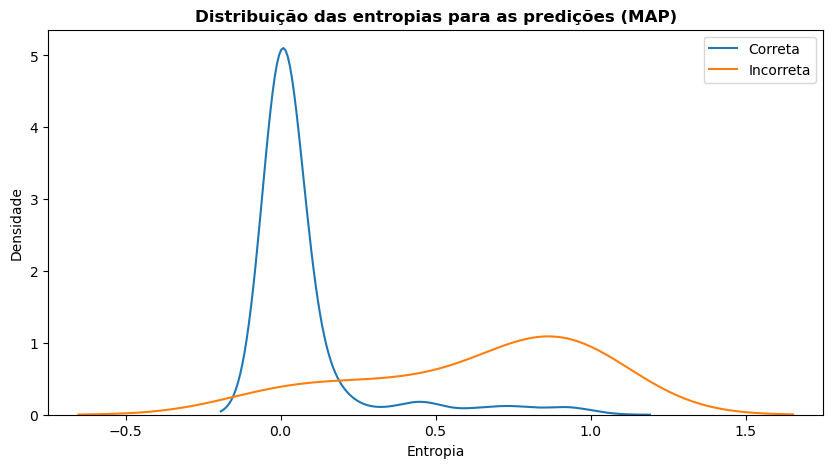

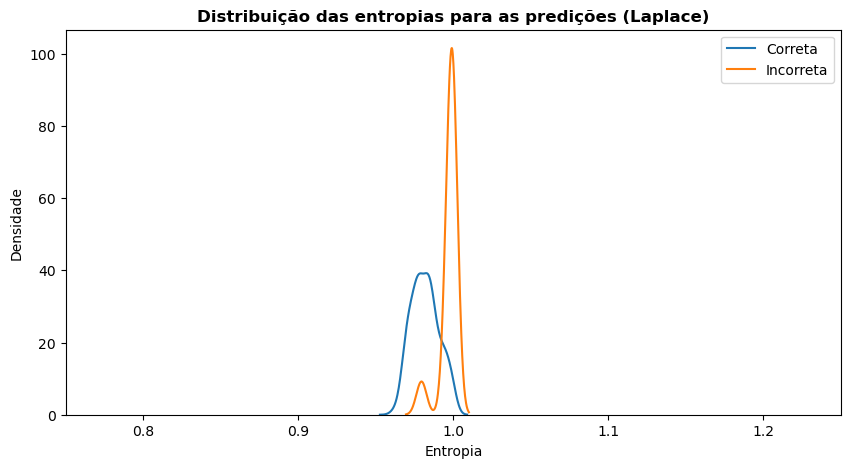

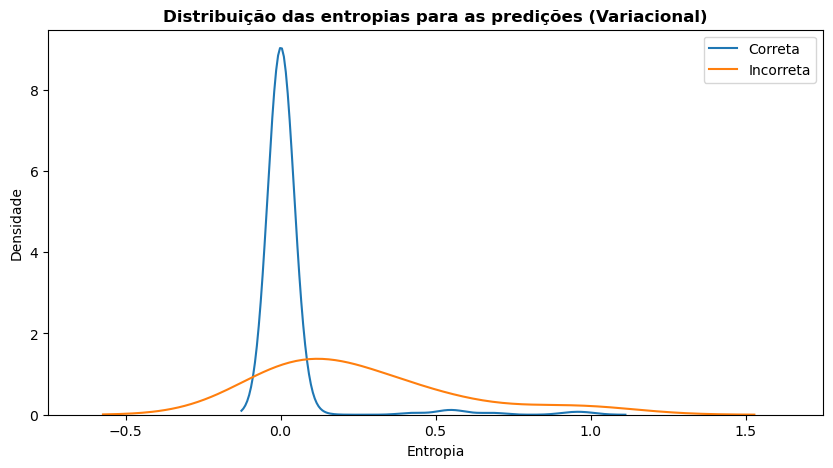

In [10]:
# Plotando as distribuições das entropias para as predições
plot(map_pred, ytest, 'MAP')
plot(lap_pred, ytest, 'Laplace', xlim=(0.75,1.25))
plot(var_pred, ytest, 'Variacional')

Cada gráfico mostra a distribuição das entropias para as predições corretas e incorretas. A entropia é uma medida de incerteza, e quanto maior a entropia, maior a incerteza. Com o preditor MAP (Maximum a Posteriori) e a Aproximação Variacional, as predições corretas tem um pico em valores menores de entropia, indicando que o modelo está mais confiante nessas predições. Nas predições icorretas, a entropia está mais espalhada, indicando que o modelo está menor confiança. Com a aproximação de laplace, o range de entropias é menor e a escala é diferente, o que sugere que esse modelo produz predições com menor incerteza, tanto para as predições corretas quanto para as incorretas.

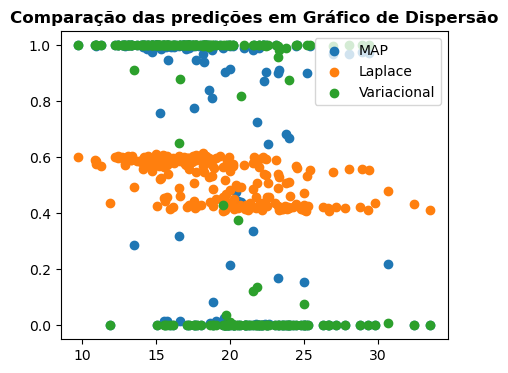

In [11]:
# Gráfico de comparação das entropias
fig = plt.subplots(figsize=(5,4))
labels, pred = zip(*preds.items())
for i in range(3):
    # Scatter Plot das predições para cada métodoa
    plt.scatter(Xtest[:, 1], pred[i].detach(), label=labels[i])

plt.legend()
plt.title('Comparação das predições em Gráfico de Dispersão', fontweight="bold")
plt.show()

Podemos ver que as predições de MAP tem maior dispersão, indicando que o modelo é mais incerto sobre suas predições.  A Aproximação de Laplace, por outro lado, parece ser mais conservadora em suas previsões, e tende a ficar mais concentrada em torno de certos valores, o que pode explicar o agrupamento no gráfico de dispersão. Por fim, a Aproximação Variacional indica que certas condições ou valores de recursos levam a previsões mais fortes em uma direção ou outra.

---

# Exercícios de "papel e caneta"

1. Derive a fórmula para a divergência KL entre duas distribuições Gaussianas univariadas, i.e., $D_\text{KL}\left(\mathcal{N}(\mu_1, \sigma_1^2) \| \mathcal{N}(\mu_2, \sigma_2^2)\right)$;


#### Resposta: 

A divergência de Kullback-Leibler (KL) entre duas distribuições de probabilidade mede o quanto uma distribuição difere de outra. Para duas distribuições Gaussianas univariadas, $\mathcal{N}(\mu_1, \sigma_1^2)$ e $\mathcal{N}(\mu_2, \sigma_2^2)$, a divergência KL é dada pela expressão:

$$D_{KL}(p\|q) = \int^{\infty}_{-\infty} p(x) \log \frac{p(x)}{q(x)} dx$$

onde $p(x)$ é a densidade de probabilidade de $\mathcal{N}(\mu_1, \sigma_1^2)$ e $q(x)$ é a densidade de probabilidade de $\mathcal{N}(\mu_2, \sigma_2^2)$. As funções de densidade para as distribuições normais são:

$$p(x) = \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)$$

$$q(x) = \frac{1}{\sqrt{2\pi\sigma_2^2}} \exp\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right)$$

Substituindo as funções de densidade na fórmula da divergência KL, temos:

$$D_{KL}(p\|q) = \int^{\infty}_{-\infty} \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right) \log \frac{\frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)}{\frac{1}{\sqrt{2\pi\sigma_2^2}} \exp\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right)} dx$$

Simplificando o logaritmo, temos:

$$ \log \left( \frac{\frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right)}{\frac{1}{\sqrt{2\pi\sigma_2^2}} \exp\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right)} \right) = \log \left( \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right) \right) - \log \left( \frac{1}{\sqrt{2\pi\sigma_2^2}} \exp\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right) \right)$$

$$ = \log \left( \frac{1}{\sqrt{2\pi\sigma_1^2}} \right) + \log \left( \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right) \right) - \log \left( \frac{1}{\sqrt{2\pi\sigma_2^2}} \right) - \log \left( \exp\left(-\frac{(x-\mu_2)^2}{2\sigma_2^2}\right) \right)$$

$$ = \log \left( \frac{\sqrt{2\pi\sigma_2^2}}{\sqrt{2\pi\sigma_1^2}} \right) - \frac{(x-\mu_1)^2}{2\sigma_1^2}  + \frac{(x-\mu_2)^2}{2\sigma_2^2}$$

$$ = \log \left( \frac{\sigma_2}{\sigma_1} \right) - \frac{(x-\mu_1)^2}{2\sigma_1^2}  + \frac{(x-\mu_2)^2}{2\sigma_2^2}$$

Substituindo o logaritmo na fórmula da divergência KL, temos:

$$D_{KL}(p\|q) = \int^{\infty}_{-\infty} p(x) \left( \log \left( \frac{\sigma_2}{\sigma_1} \right) - \frac{(x-\mu_1)^2}{2\sigma_1^2}  + \frac{(x-\mu_2)^2}{2\sigma_2^2} \right) dx$$

$$ = \log \left( \frac{\sigma_2}{\sigma_1} \right) - \int^{\infty}_{-\infty} \frac{(x-\mu_1)^2}{2\sigma_1^2} p(x) dx + \int^{\infty}_{-\infty} \frac{(x-\mu_2)^2}{2\sigma_2^2} p(x) dx$$

$$ = \log \left( \frac{\sigma_2}{\sigma_1} \right) - \underbrace{ \frac{1}{2\sigma_1^2} \int^{\infty}_{-\infty} (x-\mu_1)^2 p(x) dx}_{(1)} + \frac{1}{2\sigma_2^2} \underbrace{\int^{\infty}_{-\infty} (x-\mu_2)^2 \frac{1}{\sqrt{2\pi\sigma_1^2}} \exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right) dx}_{(2)}$$

Podemos ver que em (1): $$ \frac{1}{2\sigma_1^2} \int^{\infty}_{-\infty} (x-\mu_1)^2 p(x) dx = \frac{1}{2}$$

Este resultado utiliza o fato de que a variância de uma distribuição Gaussiana, $\sigma_1$ é igual à integral do quadrado do desvio da média, ponderada pela própria distribuição.

Em (2), a integral pode ser vista como a esperança de $(x-\mu_2)^2$ com relação à distribuição $\mathcal{N}(\mu_1, \sigma_1^2)$, que é a variância da distribuição. Portanto, podemos decompor $(x-\mu_2)^2$:

$$(x-\mu_1 + \mu_1 - \mu_2)^2 = (x-\mu_1)^2 + (\mu_1 - \mu_2)^2 + 2(x-\mu_1)(\mu_1 - \mu_2)$$

- A integral de $(x-\mu_1)^2$ é a variância da distribuição $\mathcal{N}(\mu_1, \sigma_1^2)$, que é $\sigma_1^2$. 
- A integral de $2(x-\mu_1)(\mu_1 - \mu_2)$ é a covariância entre as variáveis, que é zero. 
- O termo $(\mu_1 - \mu_2)^2$ é constante, então a integral é o próprio termo. 

Portanto, a integral de $(x-\mu_2)^2$ é igual a $(\sigma_1^2 + (\mu_1 - \mu_2)^2)$.

Substituindo os resultados de (1) e (2) na fórmula da divergência KL, temos:

$$D_{KL}(p\|q) = \log \left( \frac{\sigma_2}{\sigma_1} \right) - \frac{1}{2} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2}$$




2. Suponha que $P$ é a família das distribuições categóricas com suporte em $\{1,\ldots, L\}$. Qual $p \in P$ possui maior entropia?

#### Resposta: 

A entropia entre duas distribuições de probabilidade é dada por:

$$H(p) = -\sum_{i=1}^L p_i \log p_i$$

Para maximizar a entropia, devemos maximizar a função acima sujeita à restrição $\sum_{i=1}^L p_i = 1$. Podemos fazer isso usando multiplicadores de Lagrange:

$$\mathcal{L}(p, \lambda) = -\sum_{i=1}^L p_i \log p_i + \lambda \left(\sum_{i=1}^L p_i - 1\right)$$

Derivando em relação a $p_i$ e igualando a zero, obtemos:

$$\frac{\partial \mathcal{L}}{\partial p_i} = -\log p_i - 1 + \lambda = 0$$
$$\log p_i = \lambda - 1$$
$$p_i = e^{\lambda - 1} \quad (1)$$

Substituindo na restrição, obtemos:

$$\sum_{i=1}^L e^{\lambda - 1} = 1 \Rightarrow L e^{\lambda - 1} = 1 \Rightarrow e^{\lambda - 1} = \frac{1}{L} \quad (2)$$

Portanto, por $(1)$ e $(2)$ a distribuição que maximiza a entropia é a distribuição uniforme, quando todos os $p_i$ são iguais a $\frac{1}{L}$. Isso faz sentido, já que isso implica que não temos informação sobre a probabilidade de cada evento, o que é o cenário de maior incerteza.

3. Use a [desigualdade de Jensen](https://en.wikipedia.org/wiki/Jensen%27s_inequality) para mostrar que a divergência KL é não-negativa.

> **Dica:** A desigualdade de Jensen afirma que, se $\varphi$ é uma função convexa, então $\varphi(\mathbb{E}[X]) \leq \mathbb{E}[\varphi(X)]$.

#### Resposta: 

Definimos a divergência KL entre duas distribuições de probabilidade $P$ e $Q$ como:

$$D_{KL}(P\|Q) = \mathbb{E}_{\theta \sim Q} \left[\log\left(\frac{Q(\theta)}{P(\theta)}\right)\right] = \int Q(\theta) \log \frac{Q(\theta)}{P(\theta)}d\theta$$ 

Seja $\varphi$ a função $\varphi(x) = -log(x)$, que é uma função convexa. Pela desigualdade de Jensen, temos que:

$$-\log \left[\mathbb{E}_{\theta \sim Q}\left(\frac{P(x)}{Q(x)}  \right)\right] \leq \mathbb{E}_{\theta \sim Q}\left[-\log\left(\frac{P(x)}{Q(x)}\right) \right]=-\log \int Q(\theta) \frac{P(\theta)}{Q(\theta)}d\theta = -log(1) = 0$$

$$-D_{KL}(P\|Q) \leq 0 \Rightarrow D_{KL}(P\|Q) \geq 0$$

4. Derive a aproximação de Laplace para a distribuição [Beta](https://en.wikipedia.org/wiki/Beta_distribution)($\alpha, \beta$). Mostre uma fórmula para valores genéricos $\alpha,\beta>1$ e a instancie para $\alpha=\beta=2$.

#### Resposta: 

A aproximação de Laplace busca construir uma aproximação para a distribuição a posteriori de um modelo Bayesiano. Em nosso caso, queremos aproximar a distribuição Beta, que é dada por:

$$f(\theta |\alpha, \beta) = \frac{\theta^{\alpha-1}(1-\theta)^{\beta-1}}{B(\alpha, \beta)}$$

Onde $B$ é a função Beta $B = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)}$ e $\alpha, \beta > 0$, são os parâmetros da distribuição. Sabemos que o método de Laplace consiste em aproximar a distribuição a posteriori por uma distribuição normal, cujos parâmetros são dados pela moda da distribuição a posteriori (m) e a curvatura da distribuição a posteriori na moda (inversa da Hessiana). A log-verossimilhança é dada por:
 
$$\log f(\theta |\alpha, \beta) = \log(\theta^{\alpha-1}(1-\theta)^{\beta-1}) - \log B(\alpha, \beta)$$

$$\log f(\theta |\alpha, \beta) = (\alpha-1)\log(\theta) + (\beta-1)\log(1-\theta) - \log B(\alpha, \beta)$$

Calculando a primeira derivada da log-verossimilhança, temos:

$$\frac{d}{d\theta} \log f(\theta|\alpha, \beta) = \frac{\alpha-1}{\theta} - \frac{\beta-1}{1-\theta}$$

Igualando a primeira derivada a zero, obtemos a moda da distribuição a posteriori:

$$\frac{\alpha-1}{\theta} - \frac{\beta-1}{1-\theta} = 0$$

Resolvendo para $\theta$, obtemos:

$$\theta(\beta-1) = (1-\theta)(\alpha-1)$$
$$\theta\beta - \theta = \alpha - 1 - \theta\alpha + \theta$$
$$\theta(\beta + \alpha - 2) = \alpha - 1$$
$$\theta = \boldsymbol{m} = \frac{\alpha - 1}{\alpha + \beta - 2}$$

A segunda derivada da log-verossimilhança é dada por:

$$\frac{d^2}{d\theta^2} \log f(\theta|\alpha, \beta) = -\frac{\alpha-1}{\theta^2} - \frac{\beta-1}{(1-\theta)^2}$$

A Hessiana é a matriz das segundas derivadas parciais da log-verossimilhança. A curvatura da distribuição a posteriori na moda é dada pela Hessiana avaliada na moda:

$$\boldsymbol{H}=-\left.\left(-\frac{\alpha-1}{\theta^2}-\frac{\beta-1}{(1-\theta)^2}\right)\right|_{\theta=m}$$

Com $\theta=\boldsymbol{m}=\frac{\alpha-1}{\alpha+\beta-2}$, substituindo na Hessiana:

$$\boldsymbol{H}=\frac{\alpha-1}{\left(\frac{\alpha-1}{\alpha+\beta-2}\right)^2}+\frac{\beta-1}{\left(1-\frac{\alpha-1}{\alpha+\beta-2}\right)^2}$$

Para $\alpha=\beta=2$, temos:

$$\boldsymbol{m}=\frac{2-1}{2+2-2}=\frac{1}{2}$$

$$\boldsymbol{H}=\frac{2-1}{\left(\frac{1}{2}\right)^2}+\frac{2-1}{\left(1-\frac{1}{2}\right)^2}=4+4=8$$
$$\boldsymbol{H^{-1}}=\frac{1}{8}$$

Dessa forma, a aproximação de Laplace para a distribuição Beta($2,2$) é uma distribuição normal com média $0.5$ e variância $0.125$. 

5. Derive a posteriori para o modelo Bayesiano com verossimilhança [Categórica](https://en.wikipedia.org/wiki/Categorical_distribution) e priori [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution), i.e.:
\begin{alignat}{2}
y_1,\ldots, y_N &\sim Cat(\mathbf{\theta})\\
\mathbf{\theta} &\sim Dirichlet(\mathbf{\alpha})
\end{alignat}
onde $\mathbf{\theta}$ e $\mathbf{\alpha}$ são vetores $L$-dimensionais.

#### Resposta:

A priori de Dirichlet é dada por:

$$f(\theta|\alpha) = \frac{1}{B(\alpha)}\prod_{i=1}^L \theta_i^{\alpha_i-1}$$

onde $\mathbf{\alpha}$ é o vetor de parâmetros da Dirichlet e $B(\mathbf{\alpha})$ é a função Beta multivariada.

A verossimilhança Categórica para as observações é:

$$f(y_1,\ldots,y_N|\theta) = \prod_{n=1}^N \prod_{i=1}^L \theta_i^{y_{n,i}}$$

onde $y_{n,i}$ é a variável indicadora que assume 1 se a observação $n$ pertence à categoria $i$ e 0 caso contrário.

Sabemos que a posteriori é proporcional ao produto da priori e da verossimilhança:

$$f(\theta|y_1,\ldots,y_N,\alpha) \propto f(y_1,\ldots,y_N|\theta)f(\theta|\alpha)$$

Substituindo as expressões da priori e da verossimilhança na expressão acima, obtemos:

$$
\begin{aligned}
f(\theta|y_1,\ldots,y_N,\alpha)  & \propto \prod_{i=1}^L \theta_i^{\alpha_i-1} \prod_{n=1}^N \prod_{i=1}^L \theta_i^{y_{n i}} \\
& =\prod_{i=1}^L \theta_i^{\left(\alpha_i-1+\sum_{n=1}^N y_{n i}\right)}
\end{aligned}$$

A posteriori é uma Dirichlet com parâmetros $\alpha_i' = \alpha_i + \sum_{n=1}^N y_{n i}$, para $i=1,\ldots,L$.